Vector field:$$u: \mathbb{R}^d \times [0,1] \to \mathbb{R}^d,\quad (x,t) \mapsto u_t(x)$$
ODE:$$dX_t=u_t(X_t)dt,\quad X_0=x_0$$
SDE:$$dX_t=u_t(X_t)dt + \sigma_tdW_t,\quad X_0=x_0$$

*Euler* simulation of the ODE:$$dX_t=u_t(X_t)dt\quad \to \quad X_{t+h}=X_t+hu_t(X_t),\ h=\Delta t$$
*Euler-Maruyama* simulation of the SDE:$$dX_t=u_t(X_t)dt+\sigma_tdW_t\quad \to \quad X_{t+h}=X_t+hu_t(X_t)+\sqrt{h}\sigma_t z_t,\ h=\Delta t,\ z_t \sim \mathcal{N}(0, I)$$

In [2]:
from abc import ABC, abstractmethod

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.distributions as D
from torch.func import jacrev, vmap
from tqdm import tqdm 

# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = 'cpu'
print(f"Using {device} device")

Using cpu device


In [3]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt, t):
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt, t):
        pass
    @abstractmethod
    def diffusion_coefficient(self, xt, t):
        pass

class Simulator(ABC):
    @abstractmethod
    def step(self, xt, t, h):
        pass
    @torch.no_grad
    def simulate(self, x, ts):
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
        return x
    @torch.no_grad
    def simulate_with_trajectory(self, x, ts):
        xs = [x.clone()]
        for t_idx in tqdm(range(len(ts) - 1)):
            t = ts[t_idx]
            h = ts[t_idx + 1] - ts[t_idx]
            x = self.step(x, t, h)
            xs.append(x.clone())
        return torch.stack(xs, dim=1)

In [4]:
class EulerSimulator(Simulator):
    def __init__(self, ode):
        self.ode = ode
    def step(self, xt, t, h):
        # x_{t+1} = x_t + h * drift(x_t, t)
        drift = self.ode.drift_coefficient(xt, t)
        return xt + h * drift

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde):
        self.sde = sde
    def step(self, xt, t, h):
        # x_{t+1} = x_t + h * drift(x_t, t) + sqrt(h) * diffusion * noise
        drift = self.sde.drift_coefficient(xt, t)
        diffusion = self.sde.diffusion_coefficient(xt, t)
        noise = torch.randn_like(xt)
        return xt + h * drift + torch.sqrt(h) * diffusion * noise

Brownian motion ($u_t=0,\ \sigma_t=\sigma$):$$dX_t=\sigma dW_t,\quad X_0=0,\ W_t \sim \mathcal{N}(0, tI)$$
Converges to Gaussian distribution $\mathcal{N}\sim\left(0,\sigma^2 t I\right)$

In [5]:
class BrownianMotion(SDE):
    def __init__(self, sigma):
        self.sigma = sigma
    def drift_coefficient(self, xt, t):
        return torch.zeros_like(xt)
    def diffusion_coefficient(self, xt, t):
        return torch.full_like(xt, self.sigma)

In [6]:
def plot_trajectories_1d(x0, simulator, ts, ax):
    if ax is None:
        ax = plt.gca()
    trajectories = simulator.simulate_with_trajectory(x0, ts)
    for trajectory_idx in range(trajectories.shape[0]):
        trajectory = trajectories[trajectory_idx, :, 0]
        ax.plot(ts.cpu(), trajectory.cpu())

100%|██████████| 499/499 [00:00<00:00, 44994.36it/s]


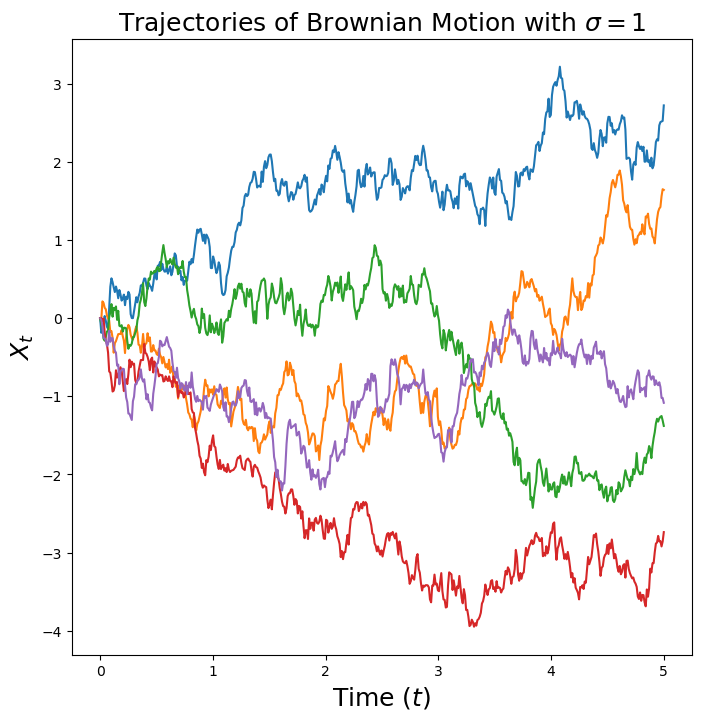

In [7]:
sigma = 1
simulation_time = 5.0
brownian_motion = BrownianMotion(sigma=sigma)
simulator = EulerMaruyamaSimulator(sde=brownian_motion)
x0 = torch.zeros(5, 1).to(device)
ts = torch.linspace(0.0, simulation_time, 500).to(device)

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_title(r'Trajectories of Brownian Motion with $\sigma=$' + str(sigma), fontsize=18)
ax.set_xlabel(r'Time ($t$)', fontsize=18)
ax.set_ylabel(r'$X_t$', fontsize=18)
plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

Ornstein-Uhlenbeck process ($u_t(X_t)=-\theta X_t,\ \sigma_t=\sigma$):$$dX_t=-\theta X_t dt + \sigma dW_t,\quad X_0=x_0$$
Converges to Gaussian distribution $\mathcal{N}\sim\left(0,\frac{\sigma^2}{2\theta}\right)$

In [8]:
class OUProcess(SDE):
    def __init__(self, theta, sigma):
        self.theta = theta
        self.sigma = sigma
    def drift_coefficient(self, xt, t):
        return -self.theta * xt
    def diffusion_coefficient(self, xt, t):
        return torch.full_like(xt, self.sigma)

100%|██████████| 999/999 [00:00<00:00, 85979.19it/s]


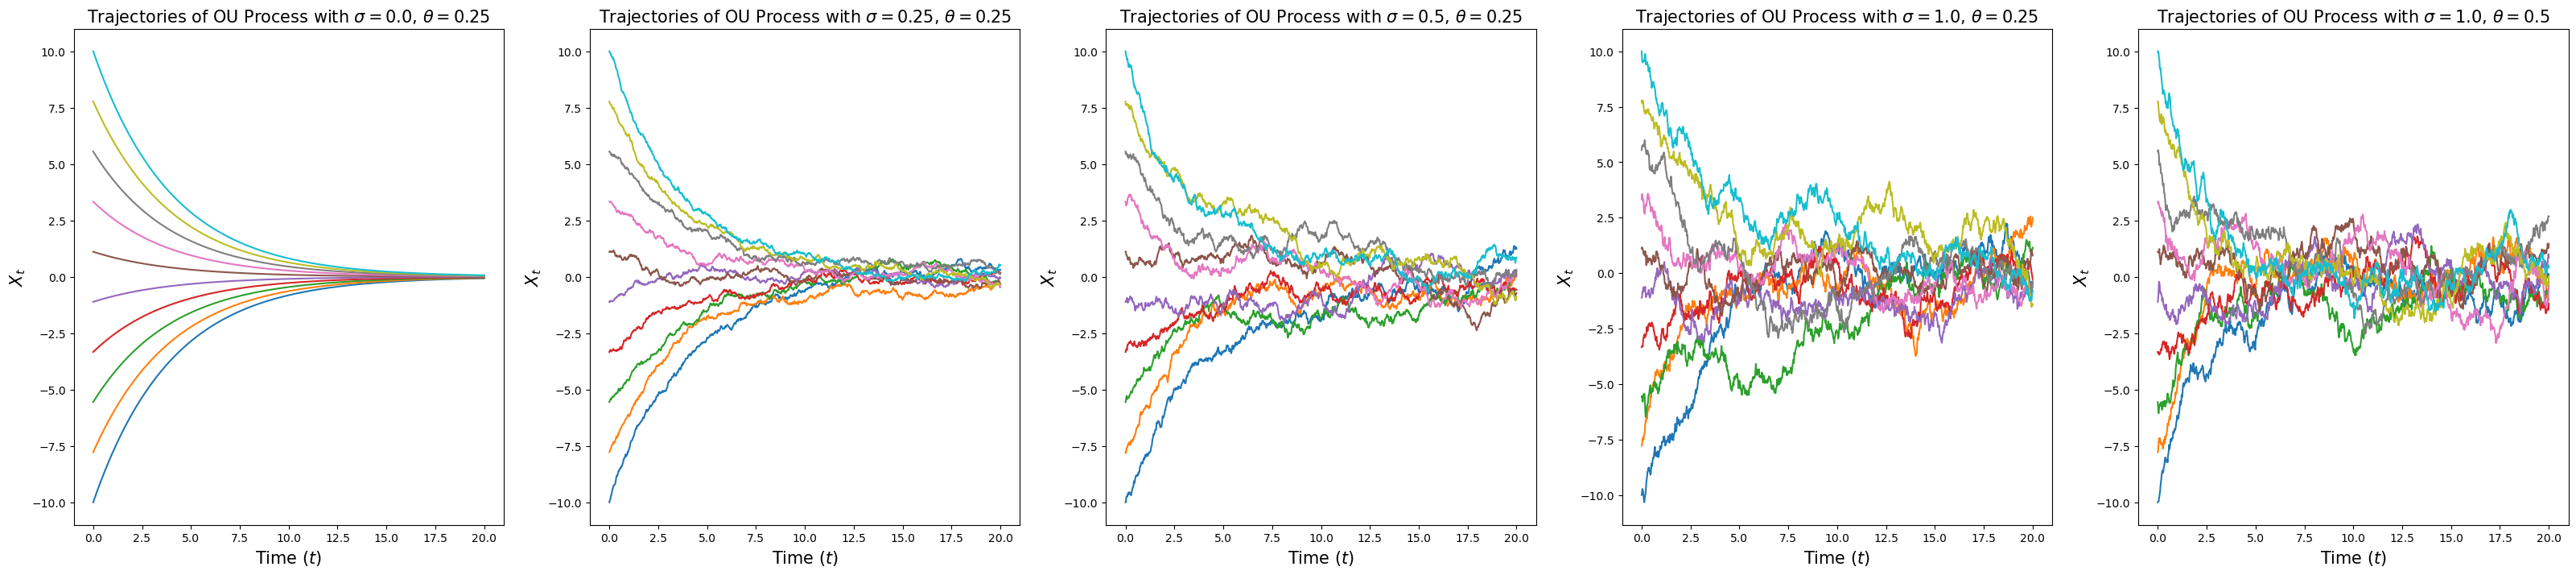

In [9]:
thetas_and_sigmas = [
    (0.25, 0.0),
    (0.25, 0.25),
    (0.25, 0.5),
    (0.25, 1.0),
    (0.50, 1.0)
]
simulation_time = 20.0
num_plots = len(thetas_and_sigmas)
fig, axes = plt.subplots(1, num_plots, figsize=(8 * num_plots, 8))

for idx, (theta, sigma) in enumerate(thetas_and_sigmas):
    ou_process = OUProcess(theta, sigma)
    simulator = EulerMaruyamaSimulator(sde=ou_process)
    x0 = torch.linspace(-10.0, 10.0, 10).view(-1, 1).to(device)
    ts = torch.linspace(0.0, simulation_time, 1000).to(device)

    ax = axes[idx]
    ax.set_title(f'Trajectories of OU Process with $\\sigma = ${sigma}, $\\theta = ${theta}', fontsize=15)
    ax.set_xlabel(r'Time ($t$)', fontsize=15)
    ax.set_ylabel(r'$X_t$', fontsize=15)
    plot_trajectories_1d(x0, simulator, ts, ax)
plt.show()

In [10]:
class Density(ABC):
    @abstractmethod
    def log_density(self, x):
        pass # (batch, dim) -> (batch, 1)
    def score(self, x):
        x = x.unsqueeze(1) # (batch, 1, dim)
        score = vmap(jacrev(self.log_density))(x) # (batch, 1, 1, 1, dim)
        return score.squeeze((1, 2, 3)) # (batch, dim)

class Sampleable(ABC):
    @abstractmethod
    def sample(self, num_samples):
        pass

In [11]:
class Gaussian(torch.nn.Module, Sampleable, Density):
    def __init__(self, mean, cov):
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)
    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov)
    def log_density(self, x):
        return self.distribution.log_prob(x).view(-1, 1)
    def sample(self, num_samples):
        return self.distribution.sample((num_samples,))

class GaussianMixture(torch.nn.Module, Sampleable, Density):
    def __init__(self, means, covs, weights):
        super().__init__()
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)
    @property
    def dim(self):
        return self.means.shape[1]
    @property
    def distribution(self):
        return D.MixtureSameFamily(
            mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
            component_distribution=D.MultivariateNormal(
                loc=self.means,
                covariance_matrix=self.covs,
                validate_args=False
            ),
            validate_args=False
        )
    def log_density(self, x):
        return self.distribution.log_prob(x).view(-1, 1)
    def sample(self, num_samples):
        return self.distribution.sample((num_samples,))
    @classmethod
    def random_2D(cls, nmodes, std, scale=10.0, seed=42):
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes)
        return cls(means, covs, weights)
    @classmethod
    def symmetric_2D(cls, nmodes, std, scale=10.0):
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1)[:nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim=1) * scale
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

In [12]:
def hist2d_sampleable(sampleable, num_samples, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples)
    ax.hist2d(samples[:, 0].cpu(), samples[:, 1].cpu(), **kwargs)

def scatter_sampleable(sampleable, num_samples, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples)
    ax.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), **kwargs)

def imshow_density(density, bins, scale, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y, indexing='xy')
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins)
    im = ax.imshow(density.cpu(), extent=[-scale, scale, -scale, scale], origin='lower', **kwargs)

def contour_density(density, bins, scale, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale, scale, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y, indexing='xy')
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins)
    im = ax.contour(density.cpu(), extent=[-scale, scale, -scale, scale], origin='lower', **kwargs)

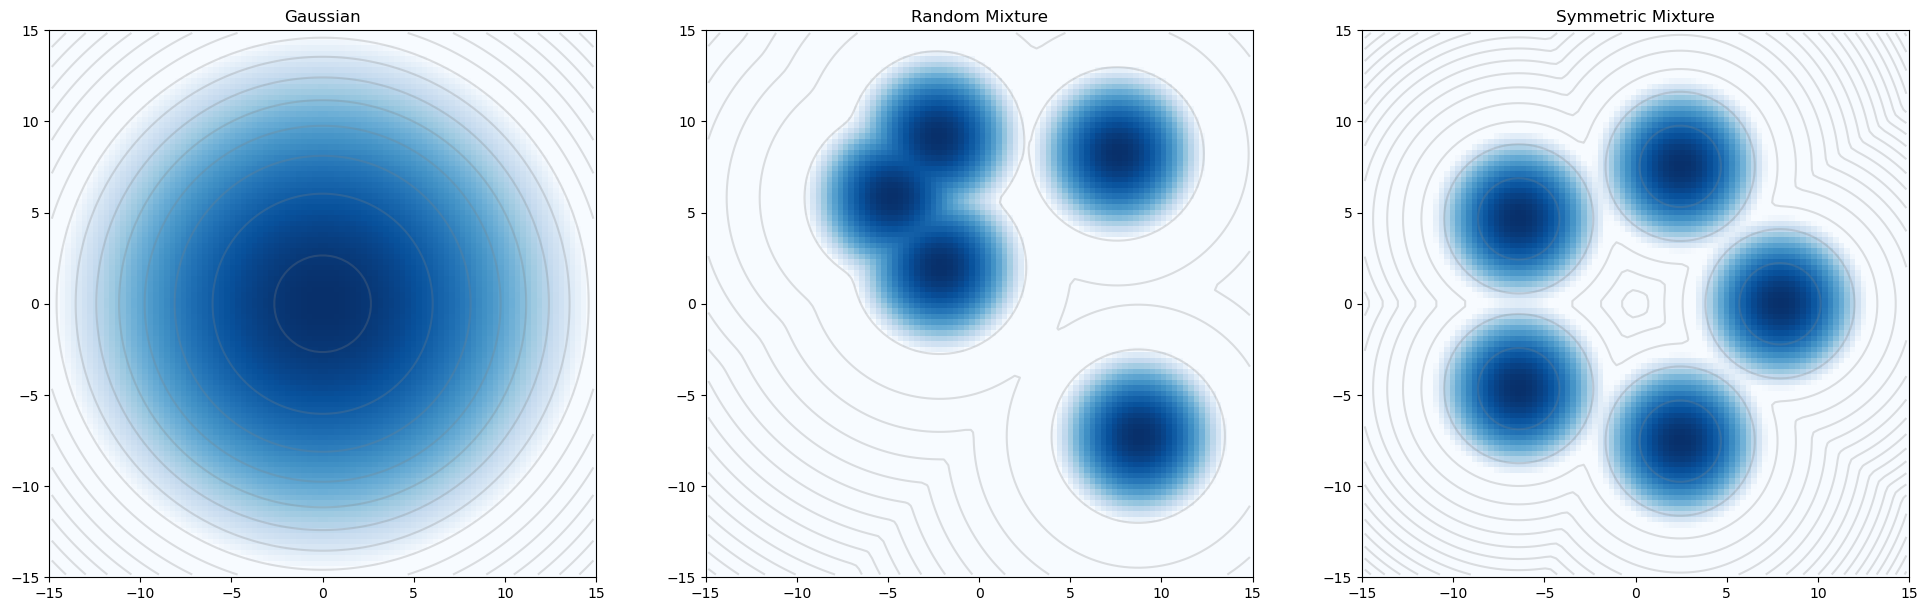

In [ ]:
densities = {
    "Gaussian": Gaussian(mean=torch.zeros(2), cov=10 * torch.eye(2)).to(device),
    "Random Mixture": GaussianMixture.random_2D(nmodes=5, std=1.0, scale=20.0, seed=42).to(device),
    "Symmetric Mixture": GaussianMixture.symmetric_2D(nmodes=5, std=1.0, scale=8.0).to(device)
}

figs, axes = plt.subplots(1, 3, figsize=(24, 8))
bins = 100
scale = 15
for idx, (name, density) in enumerate(densities.items()):
    ax = axes[idx]
    ax.set_title(name)
    imshow_density(density, bins, scale, ax, vmin=-15, cmap=plt.get_cmap('Blues'))
    contour_density(density, bins, scale, ax, colors='grey', linestyles='solid', alpha=0.25, levels=20)
plt.show()

Score:$$s_t(x) = \nabla \log p(x) = \frac{\nabla p(x)}{p(x)}$$
Langevin dynamics:$$dX_t = \frac{1}{2} \sigma^2 s_t(X_t) dt + \sigma dW_t = \frac{1}{2} \sigma^2\nabla \log p(X_t) dt + \sigma dW_t$$
Converges to distribution with density $p(x)$

In [14]:
class LangevinSDE(SDE):
    def __init__(self, sigma, density):
        self.sigma = sigma
        self.density = density
    def drift_coefficient(self, xt, t):
        return 0.5 * (self.sigma ** 2) * self.density.score(xt)
    def diffusion_coefficient(self, xt, t):
        return torch.full_like(xt, self.sigma)

In [15]:
def get_trajectory_snapshot_indices(num_timesteps, step_size):
    if step_size == 1:
        return torch.arange(num_timesteps)
    return torch.cat([torch.arange(0, num_timesteps -1, step_size), torch.tensor([num_timesteps - 1])])

def plot_distribution_evolution(num_samples, source_distribution, simulator, target_density, timesteps, plot_interval, bins, scale):
    x0 = source_distribution.sample(num_samples)
    traj_full = simulator.simulate_with_trajectory(x0, timesteps)
    indices_to_plot = get_trajectory_snapshot_indices(len(timesteps), plot_interval)
    snapshot_timesteps = timesteps[indices_to_plot]
    snapshot_states = traj_full[:, indices_to_plot]

    num_snapshots = len(snapshot_timesteps)
    fig, axes = plt.subplots(2, num_snapshots, figsize=(8 * num_snapshots, 16))
    axes = axes.reshape((2, num_snapshots))

    for i in range(num_snapshots):
        t = snapshot_timesteps[i].item()
        current_samples = snapshot_states[:, i]

        ax_scatter = axes[0, i]
        imshow_density(target_density, bins, scale, ax_scatter, vmin=-15, alpha=0.25, cmap=plt.get_cmap('Blues'))
        ax_scatter.scatter(current_samples[:, 0].cpu(), current_samples[:, 1].cpu(), marker='x', color='black', alpha=0.5, s=10)
        ax_scatter.set_title(f'Particles at t={t:.1f}', fontsize=15)
        ax_scatter.set_xticks([])
        ax_scatter.set_yticks([])

        ax_kde = axes[1, i]
        imshow_density(target_density, bins, scale, ax_kde, vmin=-15, alpha=0.5, cmap=plt.get_cmap('Blues'))
        sns.kdeplot(x=current_samples[:, 0].cpu(), y=current_samples[:, 1].cpu(), alpha=0.5, ax=ax_kde, color='grey', fill=False)
        ax_kde.set_title(f'Estimated Density at t={t:.1f}', fontsize=15)
        ax_kde.set_xticks([])
        ax_kde.set_yticks([])
        ax_kde.set_xlabel("")
        ax_kde.set_ylabel("")
    
    plt.tight_layout()
    plt.show()

100%|██████████| 999/999 [00:03<00:00, 273.44it/s]


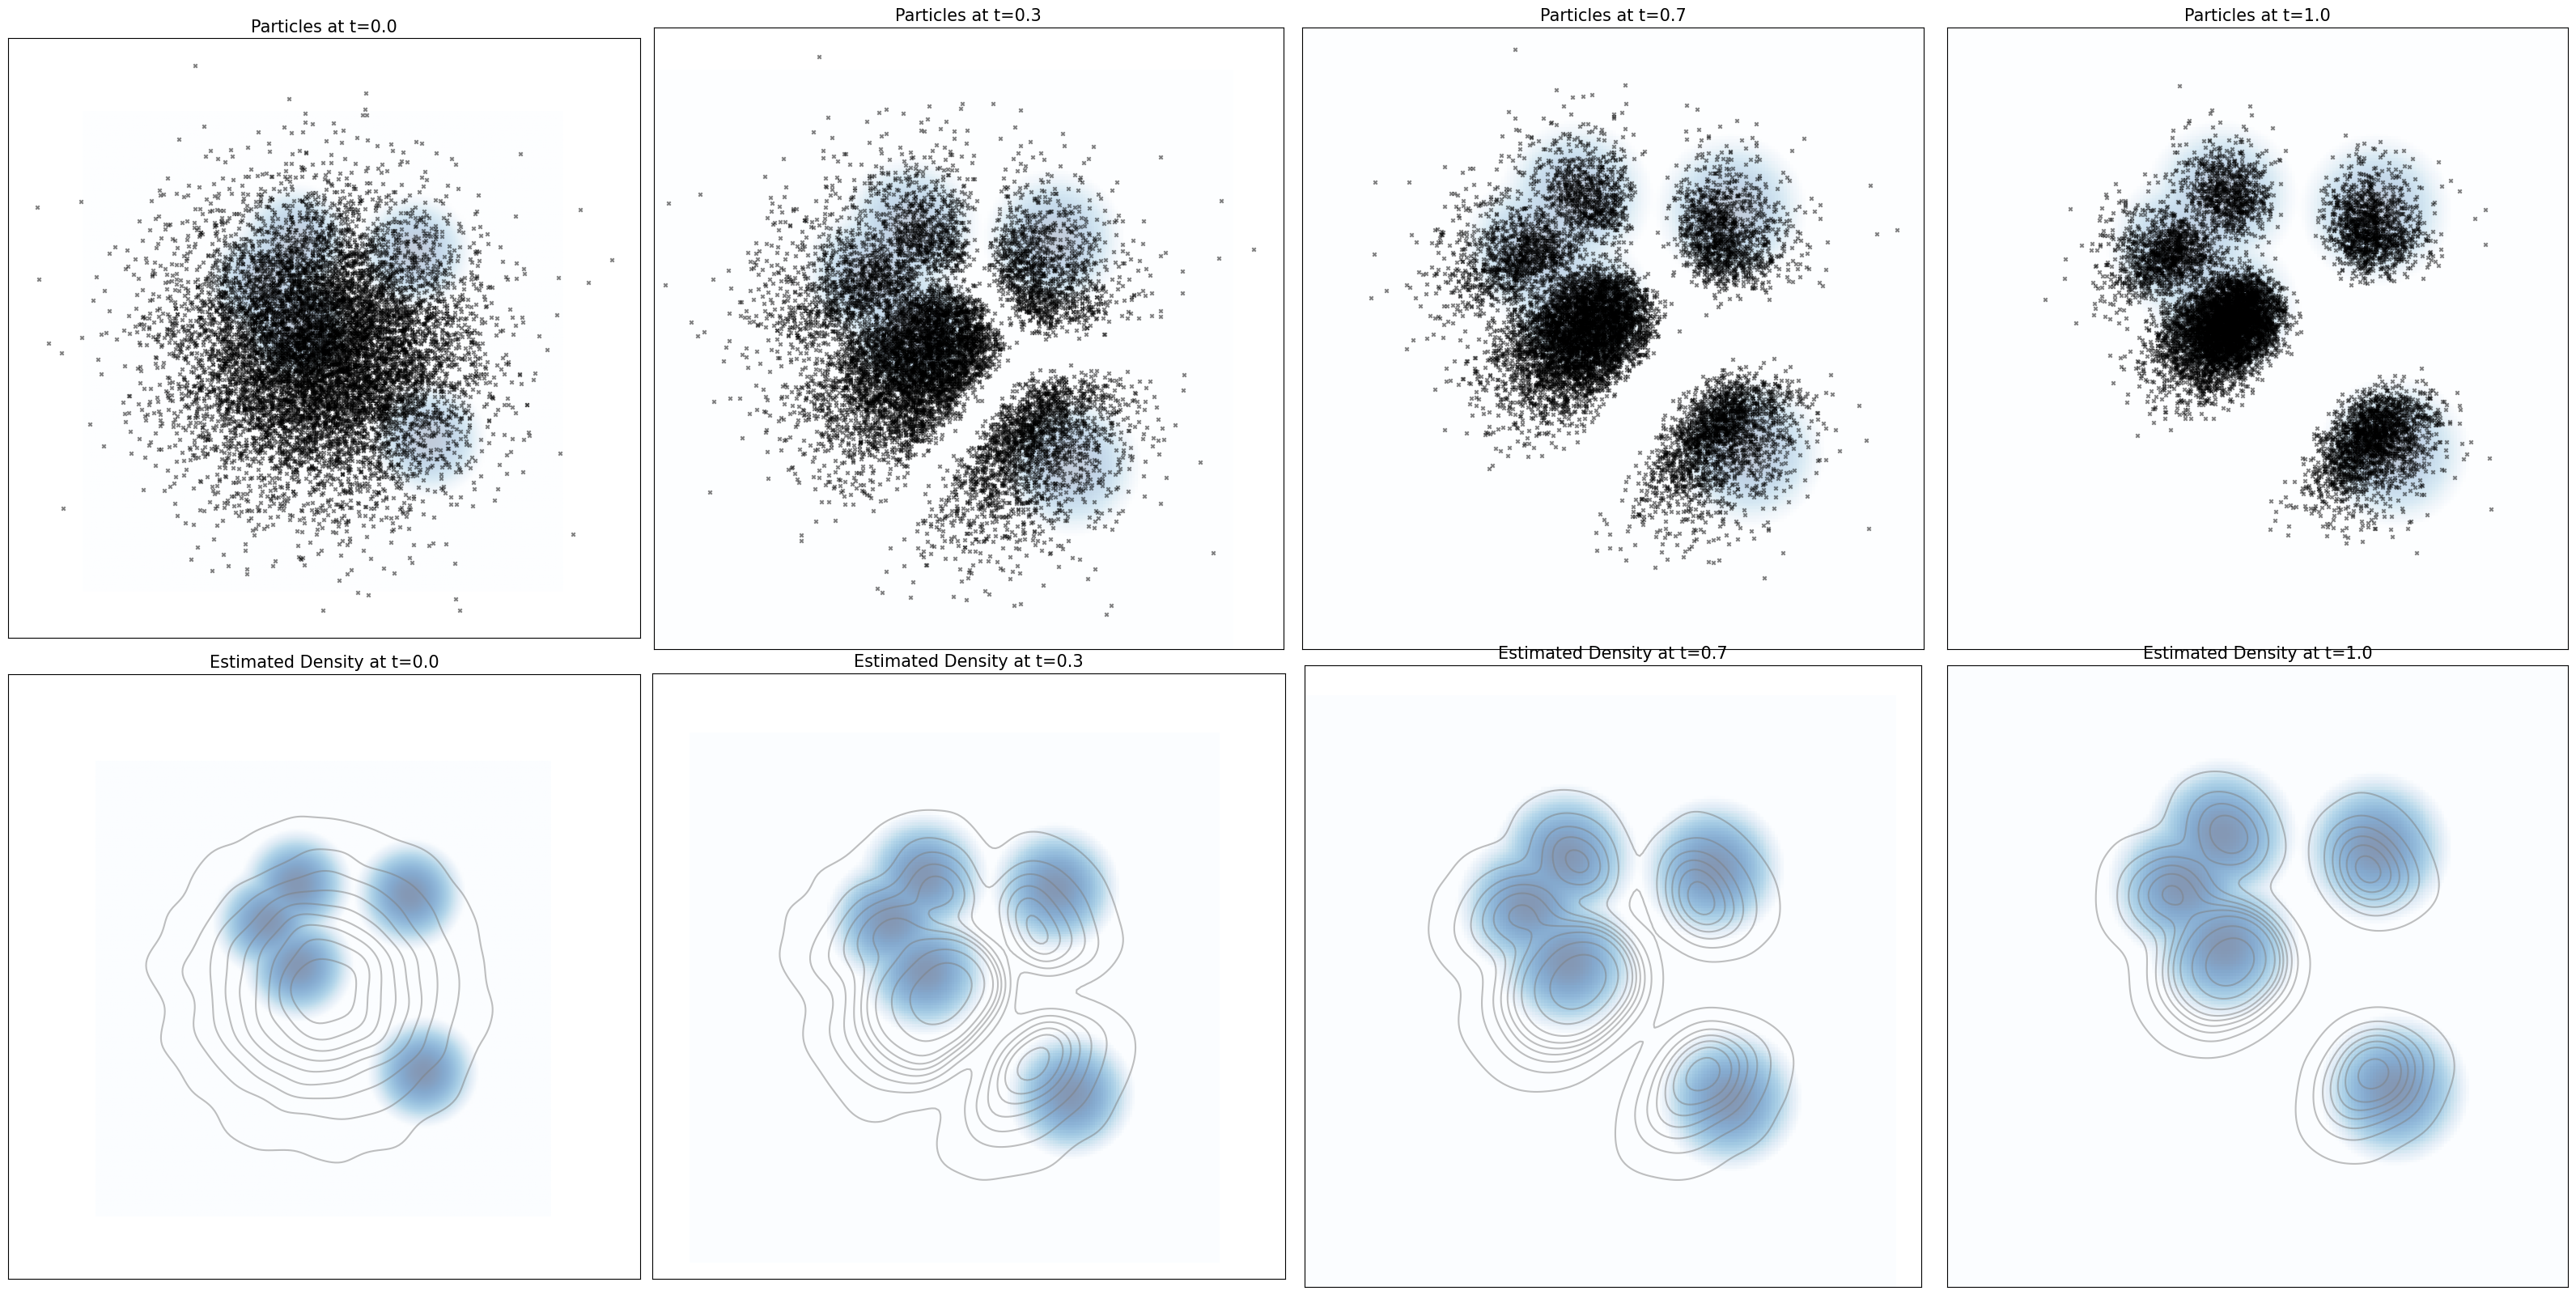

In [16]:
target_density = GaussianMixture.random_2D(nmodes=5, std=0.75, scale=15.0, seed=42).to(device)
# target_density = GaussianMixture.symmetric_2D(nmodes=5, std=0.75, scale=5)
sde = LangevinSDE(sigma=1.0, density=target_density)
simulator = EulerMaruyamaSimulator(sde)

plot_distribution_evolution(num_samples=10000, source_distribution=Gaussian(mean=torch.zeros(2), cov=20 * torch.eye(2)).to(device), simulator=simulator, target_density=target_density, timesteps=torch.linspace(0,1,1000).to(device), plot_interval=334, bins=200, scale=15)

In [17]:
from celluloid import Camera
from IPython.display import HTML

def animate_distribution_evolution(num_samples, source_distribution, simulator, target_density, timesteps, animate_interval, bins, scale, save_path='dynamics_animation.mp4'):
    x0 = source_distribution.sample(num_samples)
    traj_full = simulator.simulate_with_trajectory(x0, timesteps)
    indices_to_animate = get_trajectory_snapshot_indices(len(timesteps), animate_interval)
    frame_timesteps = timesteps[indices_to_animate]
    frame_states = traj_full[:, indices_to_animate]

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes = axes.reshape((2,))
    camera = Camera(fig)
    
    for i in range(len(frame_timesteps)):
        t = frame_timesteps[i].item()
        current_samples = frame_states[:, i]
        
        ax_scatter = axes[0]
        imshow_density(target_density, bins, scale, ax_scatter, vmin=-15, alpha=0.25, cmap=plt.get_cmap('Blues'))
        ax_scatter.scatter(current_samples[:, 0].cpu(), current_samples[:, 1].cpu(), marker='x', color='black', alpha=0.5, s=10)
        ax_scatter.set_title(f'Particles at t={t:.1f}', fontsize=15)
        ax_scatter.set_xticks([])
        ax_scatter.set_yticks([])

        ax_kde = axes[1]
        imshow_density(target_density, bins, scale, ax_kde, vmin=-15, alpha=0.25, cmap=plt.get_cmap('Blues'))
        sns.kdeplot(x=current_samples[:, 0].cpu(), y=current_samples[:, 1].cpu(), alpha=0.5, ax=ax_kde, color='grey', fill=False)
        ax_kde.set_title(f'Estimated Density at t={t:.1f}', fontsize=15)
        ax_kde.set_xticks([])
        ax_kde.set_yticks([])
        ax_kde.set_xlabel("")
        ax_kde.set_ylabel("")
        camera.snap()
    
    animation = camera.animate()
    animation.save(save_path)
    plt.close(fig)
    return HTML(animation.to_html5_video())

In [20]:
target_density = GaussianMixture.random_2D(nmodes=5, std=0.75, scale=15.0, seed=42).to(device)
sde = LangevinSDE(sigma=0.6, density=target_density)
simulator = EulerMaruyamaSimulator(sde)

animate_distribution_evolution(num_samples=10000, source_distribution=Gaussian(mean=torch.zeros(2), cov=20 * torch.eye(2)).to(device), simulator=simulator, target_density=target_density, timesteps=torch.linspace(0, 10.0, 2000).to(device), animate_interval=30, bins=200, scale=15)

100%|██████████| 1999/1999 [00:06<00:00, 323.37it/s]
